# Смертность ковенфолка в результате естественных причин


Чтобы определить, выжил ли человек в текущий год или скончался в результате естественных причин сначала определяем вероятность смерти в зависимости от возраста. Затем создадаем подключение к базе данных, генерируем запрос, чтобы определить умерших в текущем году и обновляем базу данных данными об умерших.

## 1. Определяем коэффициент вероятности смерти

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Представим вероятность смерти жителя ковенанта в виде коэффециента, который зависит от возраста жителя.

Возьмем данные о значений повозрастной вероятности смерти из csv файла (это, конечно, не реальные данные):

In [2]:
df_prob = pd.read_csv('C:\\Users\\Ggg\\probability.csv')

print('Data downloaded and read into a dataframe!')

Data downloaded and read into a dataframe!


dataframe состоит из двух столбцов 'Age' и 'Probability'

In [4]:
df_prob.head()

,Age,Probability
0,0,0.029248
1,1,0.027919
2,2,0.027124
3,3,0.026772
4,4,0.026779


Text(0, 0.5, 'Вероятность смерти, %')

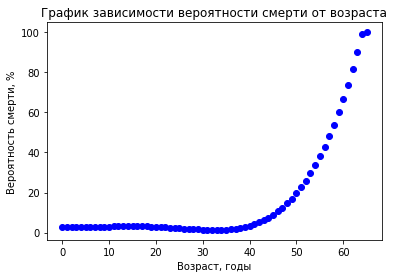

In [5]:
plt.scatter(df_prob.Age, df_prob.Probability*100,  color='blue')
plt.title('График зависимости вероятности смерти от возраста')
plt.xlabel("Возраст, годы")
plt.ylabel("Вероятность смерти, %")

Чтобы удобнее было использовать коэффициент, аппроксимируем зависимость, используя полиномиальную регрессию

In [6]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

In [7]:
train_x = np.asanyarray(df_prob[['Age']])
train_y = np.asanyarray(df_prob[['Probability']])

Используем полином 4 степени:

In [8]:
poly = PolynomialFeatures(degree=4)
train_x_poly = poly.fit_transform(train_x)

Теперь мы можем рассматривать это как проблему «линейной регрессии».
Таким образом можно использовать функцию LinearRegression() для ее решения:

In [9]:
clf = linear_model.LinearRegression()
train_y_ = clf.fit(train_x_poly, train_y)
# The coefficients
print ('Coefficients: ', clf.coef_)
print ('Intercept: ',clf.intercept_)

Coefficients:  [[ 0.00000000e+00  1.86712552e-04  1.64007656e-04 -1.24231645e-05
   2.09498001e-07]]
Intercept:  [0.02480006]


Построим график вероятности смерти с линией регрессии:

Text(0, 0.5, 'Вероятность смерти, %')

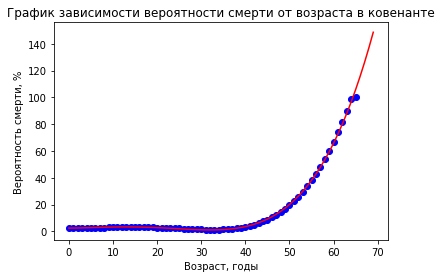

In [11]:
plt.scatter(df_prob.Age, df_prob.Probability*100,  color='blue')
XX = np.arange(0.0, 70, 1)
yy = clf.intercept_[0]+ clf.coef_[0][1]*XX+ clf.coef_[0][2]*np.power(XX, 2)+ clf.coef_[0][3]*np.power(XX, 3)+ clf.coef_[0][4]*np.power(XX, 4)
plt.plot(XX, yy*100, '-r' )
plt.title('График зависимости вероятности смерти от возраста в ковенанте')
plt.xlabel("Возраст, годы")
plt.ylabel("Вероятность смерти, %")

Конечно, вероятность смерти не может быть больше 100%, но на работу алгоритма никак не влияет факт, что аппроксимированная вероятность смерти при возрасте старше 65 лет > 1.

Сохраним значения коэффициентов регрессионной кривой в файл coefficient.txt

In [12]:
with open('coefficient.txt', 'w') as writefile:
    writefile.write(str(clf.intercept_[0]))
    writefile.write('\n')
    flag = 0
    for coef in clf.coef_[0]:
        if flag:
            writefile.write(str(coef))
            writefile.write('\n')
        flag = 1

## 2. Добавление данных о смерти в текущем году

#### Подключение к базе данных и добавление в нее данных о смертях за текущий год

In [13]:
import os
import pymysql
import pymysql.cursors
from mysql.connector import Error

Создадим подключение к базе данных mysql "ars_magica". Изменения вносим в таблицу covenfolk_1:

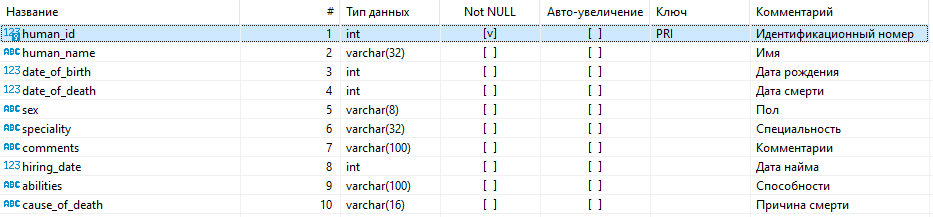

In [14]:
connection = pymysql.connect(host='localhost',
                             user='root',
                             password='GfhjkmVfqCREK7250',                             
                             db='ars_magica',
                             charset='utf8mb4',
                             cursorclass=pymysql.cursors.DictCursor) 
print ("connect successful!!")

connect successful!!


In [15]:
def execute_query(connection, query):
    mycursor = connection.cursor()
    try:
        mycursor.execute(query)
        myresult = mycursor.fetchall()
        connection.commit()
        print("Query successful")
        print ("cursor.description: ", mycursor.description) 
        print() 
        for row in mycursor:
            print(row)
        return myresult
    except Error as err:
        print(f"Error: '{err}'")

Прочитаем значения коэффициентов из файла coefficient.txt.

In [16]:
file = open("coefficient.txt", "r")
f = file.read()
coefficient = []
lines = f.split("\n")
for i in range(len(lines)-1):
    coefficient.append(float(lines[i]))

Задаем текущий год:

In [17]:
year = 1262

Создаем запрос, который определяет, кто из жителей ковенанта умирает в текущем году в зависимости от его возраста и выпадения случайного числа.

In [18]:
query_select = """SELECT IF(RAND() <=
    (%e*POW(%d - date_of_birth, 4) + 
    %e*POW(%d - date_of_birth, 3) + 
    %e*POW(%d - date_of_birth, 2) 
    + %e*(%d - date_of_birth) + %e)
    AND date_of_death IS NULL AND date_of_birth < %d, human_id, NULL) as human_id
    FROM covenfolk_1
    """%(coefficient[4], year, coefficient[3], year, coefficient[2], year, coefficient[1], year, coefficient[0], year)
print(query_select)

SELECT IF(RAND() <=
    (2.094980e-07*POW(1262 - date_of_birth, 4) + 
    -1.242316e-05*POW(1262 - date_of_birth, 3) + 
    1.640077e-04*POW(1262 - date_of_birth, 2) 
    + 1.867126e-04*(1262 - date_of_birth) + 2.480006e-02)
    AND date_of_death IS NULL AND date_of_birth < 1262, human_id, NULL) as human_id
    FROM covenfolk_1
    


Выполняем запрос SELECT:

In [19]:
results = execute_query(connection, query_select)

Query successful
cursor.description:  (('human_id', 3, None, 11, 11, 0, True),)



Создаем список из 'human_id' людей, умерших в текущем году:

In [20]:
dead_this_year = [row['human_id'] for row in results if row['human_id'] is not None]

In [21]:
print(dead_this_year)

[82, 83, 85]


In [22]:
for i in range(len(dead_this_year)):
    sql_update_query = """UPDATE covenfolk_1 SET date_of_death = %d, cause_of_death = 'natural cause' WHERE human_id = %d"""%(year, dead_this_year[i])
    print(sql_update_query)
    execute_query(connection, sql_update_query)

UPDATE covenfolk_1 SET date_of_death = 1262, cause_of_death = 'natural cause' WHERE human_id = 82
Query successful
cursor.description:  None

UPDATE covenfolk_1 SET date_of_death = 1262, cause_of_death = 'natural cause' WHERE human_id = 83
Query successful
cursor.description:  None

UPDATE covenfolk_1 SET date_of_death = 1262, cause_of_death = 'natural cause' WHERE human_id = 85
Query successful
cursor.description:  None

